In [1]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

print("CUDA AVALIABLE:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("DEVICE:", torch.cuda.get_device_name(torch.cuda.current_device()))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"
print(f"Using {device} device")

# Custom Imports
from data_gen import read_data, dset_size


CUDA AVALIABLE: True
DEVICE: NVIDIA RTX A4500
Using cpu device


## Load Data

In [2]:
file = "data.hdf5"
complex_type = torch.complex64
states, H = read_data(file, dim=2, label="train", i_start=0, i_end=1000)

In [3]:
d = torch.tensor(H[0, 0], dtype=complex_type).to(device)
d, d.shape

(tensor([[-0.8918+0.j,  0.0000+0.j],
         [ 0.0000+0.j, -0.7244+0.j]]),
 torch.Size([2, 2]))

In [6]:
torch.linalg.matrix_exp(d)

tensor([[0.4099+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.4846+0.j]])

# Try a Model with Complex Data

In [70]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.flatten = nn.Flatten(start_dim=0, end_dim=-1)
      self.dense1= nn.Sequential(
        nn.Linear(4, 2, dtype=complex_type),
        nn.Sigmoid()
      )
      self.dense2 = nn.Sequential(
        nn.Linear(2, 1, dtype=complex_type),
        nn.Sigmoid()
      )

    # x represents our data
    def forward(self, x):

      x = self.flatten(x)
      print(x)
      x = self.dense1(x)
      x = self.dense2(x)

      return x

model = Net().to(device)
print(model)

NameError: name 'complex_type' is not defined

In [7]:
model(d)

tensor([-0.8918+0.j,  0.0000+0.j,  0.0000+0.j, -0.7244+0.j], device='cuda:0')


tensor([0.6411+0.1663j], device='cuda:0', grad_fn=<SigmoidBackward0>)

# Make a PyTorch Data Loader for Data

In [120]:
class timeStepData(Dataset):
    def __init__(self, hfile, dim, label, complex_type=torch.complex128, preload=True, device=None):
        self.hfile = hfile
        self.dim = dim
        self.shape = dset_size(hfile, dim, label)
        self.label = label
        self.complex_type = complex_type

        self.preload=preload
        if preload:
            self.data = read_data(self.hfile, self.dim, self.label, 0, self.shape[0]+1)

    def __len__(self):
        return self.shape[0]*(self.shape[1]-1)

    def __getitem__(self, idx):
       entry_idx = int(idx/(self.shape[1]-1))
       time_idx = idx - entry_idx*(self.shape[1]-1)
       if self.preload:
            states, Hs = self.data[0][entry_idx:entry_idx+1], self.data[1][entry_idx:entry_idx+1]
       else:
            states, Hs = read_data(self.hfile, self.dim, self.label, entry_idx, entry_idx+1)
       state = states[0, time_idx]
       H = Hs[0, time_idx]
       next_state = states[0, time_idx+1]
       
       input_tensor = torch.tensor(np.concatenate((state.flatten(), H.flatten())), dtype=self.complex_type)
       output_tensor = torch.tensor(next_state.flatten(), dtype=self.complex_type)

       if device is not None:
        input_tensor = input_tensor.to(device)
        output_tensor = output_tensor.to(device)

       return input_tensor, output_tensor

class seqData(Dataset):
    def __init__(self, hfile, dim, label):
        self.hfile = hfile
        self.dim = dim
        self.shape = dset_size(hfile, dim, label)

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, idx):
       states, Hs = read_data(self.hfile, self.dim, self.label, idx, idx+1)
       return states, idx



In [146]:
hfile = "data.hdf5"
dim = 2
batch_size = 100000
train_data = timeStepData(hfile, dim, "train", preload=True, device=device)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = timeStepData(hfile, dim, "test", preload=True, device=device)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Make a Next Step Predicting Network

In [174]:
class StepPredNet(nn.Module):
    def __init__(self, dim, complex_type=torch.complex128):
      super(StepPredNet, self).__init__()
      self.dim = dim
      self.complex_type = complex_type
      self.dense1= nn.Sequential(
        nn.Linear(dim + dim**2, 10*dim, dtype=self.complex_type, bias=True),
        nn.Sigmoid()
      )
      self.dense2 = nn.Sequential(
        nn.Linear(10*dim, 2*dim, dtype=self.complex_type, bias=True),
        nn.Sigmoid()
      )
      self.dense3 = nn.Sequential(
        nn.Linear(2*dim, dim, dtype=self.complex_type, bias=True),
        nn.Sigmoid()
      )

    # x represents our data
    def forward(self, x):

      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)

      return x

In [175]:
model = StepPredNet(dim=2).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

print(model)
# Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

StepPredNet(
  (dense1): Sequential(
    (0): Linear(in_features=6, out_features=20, bias=True)
    (1): Sigmoid()
  )
  (dense2): Sequential(
    (0): Linear(in_features=20, out_features=4, bias=True)
    (1): Sigmoid()
  )
  (dense3): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


In [176]:
def train_one_epoch(epoch_index, tb_writer, training_loader, loss_fn):
    running_loss = 0.
    last_loss = 0.

    batch_size = training_loader.batch_size
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm(enumerate(training_loader), total=len(training_loader)):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % batch_size == batch_size-1:
            last_loss = running_loss / batch_size # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # running_loss = 0.

    return running_loss/len(training_loader)

In [177]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

train_loss = []
val_loss = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
writer = SummaryWriter('runs/timestep_solver')
epoch_number = 0

EPOCHS = 1000

best_vloss = 1_000_000.

training_loader = train_dataloader
validation_loader = test_dataloader

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, training_loader=training_loader, loss_fn=loss_fn)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    train_loss.append(avg_loss)
    val_loss.append(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


LOSS train 0.741556537815334 valid 0.7354393015252999
EPOCH 2:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.74086363581663 valid 0.7348006207185361
EPOCH 3:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.7401725193073747 valid 0.7341638824807253
EPOCH 4:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.7394832943353997 valid 0.7335292186279093
EPOCH 5:


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


LOSS train 0.7387960939780072 valid 0.7328966593224584
EPOCH 6:


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


LOSS train 0.738111002345394 valid 0.7322663050465553
EPOCH 7:


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


LOSS train 0.7374280407733588 valid 0.7316382734343042
EPOCH 8:


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


KeyboardInterrupt: 

In [135]:
np.array(psi_next.cpu())

array([ 0.01567732+0.14814522j, -0.97666745-0.15068713j])

In [7]:
def mat_exp_using_torch(H_tensor, dt):
    return torch.linalg.matrix_exp(-1.0j*dt*H_tensor)


In [20]:
torch.linalg.norm(psi@U)

tensor(1.0000, dtype=torch.float64)

In [17]:
U

tensor([[1.0000+0.0024j, 0.0000+0.0000j],
        [0.0000+0.0000j, 1.0000+0.0066j]], dtype=torch.complex128)

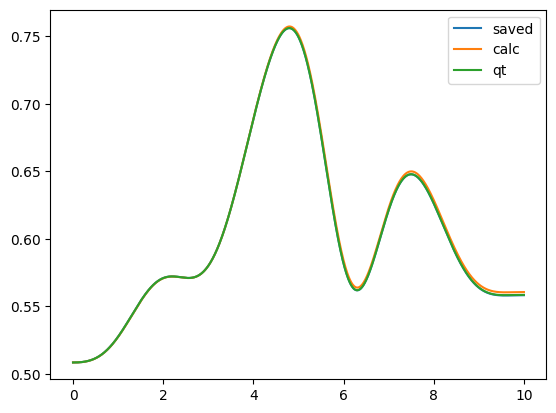

In [47]:
i = 1
states, H = read_data("data.hdf5", 2, "train", i, i+1)
H0 = H[0,0]
psi0 = states[0,0]

t_end=10
dt = 0.01

# model.eval()

# Disable gradient computation and reduce memory consumption.
# state_list = [psi0]
# with torch.no_grad():
#     for i in range(H.shape[1]-1):
#         input_tensor = torch.tensor(np.concatenate((state_list[-1].flatten(), H[0,i].flatten())), dtype=torch.complex128).to(device)
#         print(input_tensor)
#         output_tensor = model(input_tensor).cpu()
#         print(output_tensor)
#         state_list.append(np.array(output_tensor))

tlist = np.arange(0, t_end+dt, dt)
def Ham(t, tlist):
    tdiff = np.abs(t-tlist)
    return qt.Qobj(H[0, min(np.argmin(tdiff), H.shape[1]-1)])
states_qt = qt.sesolve(lambda t, args: Ham(t, tlist), qt.Qobj(psi0), tlist=tlist)
prob0_qt = [np.abs(s[0][0][0])**2 for s in states_qt.states]

# Disable gradient computation and reduce memory consumption.
state_list = [psi0]
with torch.no_grad():
    for i in range(H.shape[1]-1):
        U = mat_exp_using_torch(torch.tensor(H[0,i], dtype=torch.complex128), dt=dt)
        psi = torch.tensor(state_list[-1], dtype=torch.complex128)
        # print(input_tensor)
        output_tensor = U@psi
        # print(output_tensor)
        state_list.append(np.array(output_tensor.cpu()))#/torch.linalg.norm(output_tensor)))

prob0 = np.abs(states[0,:,0])**2
# t_end=10
# dt = 0.1
t_list = np.arange(0, t_end+dt, dt)
states_calc = [qt.Qobj(x) for x in state_list]
prob0_calc = [np.abs(s[0][0][0])**2 for s in states_calc]
plt.plot(t_list, prob0, label="saved")
plt.plot(t_list, prob0_calc, label="calc")
plt.plot(t_list, prob0_qt, label="qt")
plt.legend()